# JFruit2 Sensitivity and Uncertainty Analysis

This tutorial will cover the application of sensitivity and uncertainty methods on JFruit2.

The purpose of an uncertainty analysis is to quantify how uncertainty in the model inputs propagates to uncertainty in the model outputs. It is *output focused*, so we are more so interested in quantifying the uncertainty of the model outputs.

A closely related concept is a sensitivity analysis, which quantifies our variation in each of our inputs causes the most variation in the model outputs. It is *input focused*, so we are interested in quantifying the identifying the model inputs that most greatly influence the outputs.

# Imports

We will first import all required dependencies.

In [6]:
import pandas as pd
import numpy as np
from jfruit2 import JFruit2
import os.path as osp

from calisim.data_model import (
	DistributionModel,
	ParameterDataType,
	ParameterSpecification,
)
from calisim.sensitivity import (
	SensitivityAnalysisMethod,
	SensitivityAnalysisMethodModel,
)
from calisim.uncertainty import (
	UncertaintyAnalysisMethod,
	UncertaintyAnalysisMethodModel,
)
from calisim.statistics import MeanSquaredError

# Observed data

We will next load the observed field data.

In [7]:
observed_data = JFruit2.get_observed_data()
observed_data

,age_d,age_h,pip,piv,pp,pv,sfstone,af,ctcs,pif,...,w,s,pf1,pf2,pf,v,dD,mSol,mSta,mSyn
0,2,1,13.778,13.778,9.8344,9.8344,0.0,0.57664,0.000267,11.961,...,0.033638,0.010665,0.98543,4.7757,0.98543,0.040303,-0.37917,0.000646,0.000103,0.004049
1,2,2,13.774,13.774,9.8308,9.8308,0.0,0.58355,0.000264,11.876,...,0.034391,0.010694,0.98872,5.1422,0.98872,0.041074,-0.74167,0.000654,0.000103,0.004054
2,2,3,13.774,13.774,9.8304,9.8304,0.0,0.59076,0.000261,11.804,...,0.035182,0.010724,0.98789,5.0852,0.98789,0.041885,-1.08540,0.000661,0.000103,0.004059
3,2,4,13.771,13.771,9.8273,9.8273,0.0,0.59815,0.000258,11.716,...,0.036000,0.010754,0.98967,5.3017,0.98967,0.042721,-1.41250,0.000668,0.000103,0.004064
4,2,5,13.767,13.767,9.8238,9.8238,0.0,0.60613,0.000254,11.619,...,0.036889,0.010784,0.99307,5.6945,0.99307,0.043629,-1.70830,0.000676,0.000103,0.004070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3787,159,20,13.827,13.827,9.8834,9.8834,0.0,194.40000,0.000611,20.593,...,190.860000,39.733000,0.94875,10.3730,0.94875,215.700000,-3046.20000,8.391700,1.092500,7.243600
3788,159,21,13.821,13.821,9.8781,9.8781,0.0,194.45000,0.000610,20.527,...,190.940000,39.733000,0.94891,12.5310,0.94891,215.780000,-3047.00000,8.392100,1.092100,7.243600
3789,159,22,13.817,13.817,9.8737,9.8737,0.0,194.50000,0.000610,20.470,...,191.030000,39.733000,0.94898,13.5650,0.94898,215.870000,-3047.80000,8.392600,1.091700,7.243600
3790,159,23,13.814,13.814,9.8711,9.8711,0.0,194.56000,0.000610,20.433,...,191.130000,39.733000,0.94902,14.1340,0.94902,215.970000,-3048.50000,8.393100,1.091300,7.243600


# Calibration procedure

## Uncertainty analysis

We will next run the calibration procedures against observed fruit water mass (w) data. In this case, we will start with an uncertainty analysis.

We begin by specifying our parameter distributions. We will calibrate 3 parameters:

- Growth.lp: Conductivity of the composite membrane for water transport (phloem)
- Growth.lxAsy: Negative asymptote of the inverse logistic curve to calculate hydraulic conductivity
- Growth.kx: Maximum slope of the inverse logistic curve to calculate hydraulic conductivity

The ranges below were identified through consultation with several scientists at both Plant and Food Research (now the Bioeconomy Science Institute) and INRAe.

In [10]:
parameter_spec = ParameterSpecification(
	parameters=[
		DistributionModel(
			name="Growth.lp",
			distribution_name="uniform",
			distribution_args=[0.002, 0.004],
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="Growth.lxAsy",
			distribution_name="uniform",
			distribution_args=[0.01, 0.015],
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="Growth.kx",
			distribution_name="uniform",
			distribution_args=[0.0019, 0.0038],
			data_type=ParameterDataType.CONTINUOUS,
		),
	]
)

We'll construct a function for our uncertainty analysis, which will return a vector of simulated fruit water mass time series data.

In [12]:
def uncertainty_func(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None
) -> float | list[float]:
    model = JFruit2()
    props = model.load_properties()
    for k in parameters:
        props[k] = parameters[k]
    model.save_properties(props)

    model.run(
        properties = osp.join("data", "out", f"{model.sim_id}.properties")
    )
    simulated_data = model.results.w.values
    return simulated_data

[We next run the uncertainty analysis using the Chaospy library](https://chaospy.readthedocs.io/en/master/).

Chaospy will perform a Monte Carlo simulation as determined by the joint distribution of our parameter specification. It will then fit a polynomial chaos expansion (PCE) surrogate model that learns the relationship between the model inputs and outputs. More specifically, Polynomial Chaos Expansion (PCE) approximates a complex model 

$$
Y = f(X_1, X_2, \dots, X_n)
$$

as a polynomial of the uncertain inputs:

$$
Y \approx \sum_{i} c_i \, \Psi_i(X_1, X_2, \dots, X_n)
$$

where:  
- $X_1, X_2, \dots, X_n$ are the **uncertain input variables**.  
- $\Psi_i$ are **orthogonal polynomials** chosen according to the input distributions:  
  - Hermite polynomials for Normal distributions  
  - Legendre polynomials for Uniform distributions  
- $c_i$ are **coefficients** fitted from the model outputs.
- $i$ are the terms in the polynomial expansion.

A secondary benefit of surrogate modelling is that we speed up the uncertainty analysis by reducing the number of executions of the simulation model; our PCE model acts as a cheaper surrogate of the full model. [A more detailed tutorial on PCE can be found here](https://maths-people.anu.edu.au/~jakeman/QuantifyingUncertainty/Tutorials/PCtutorial.html).

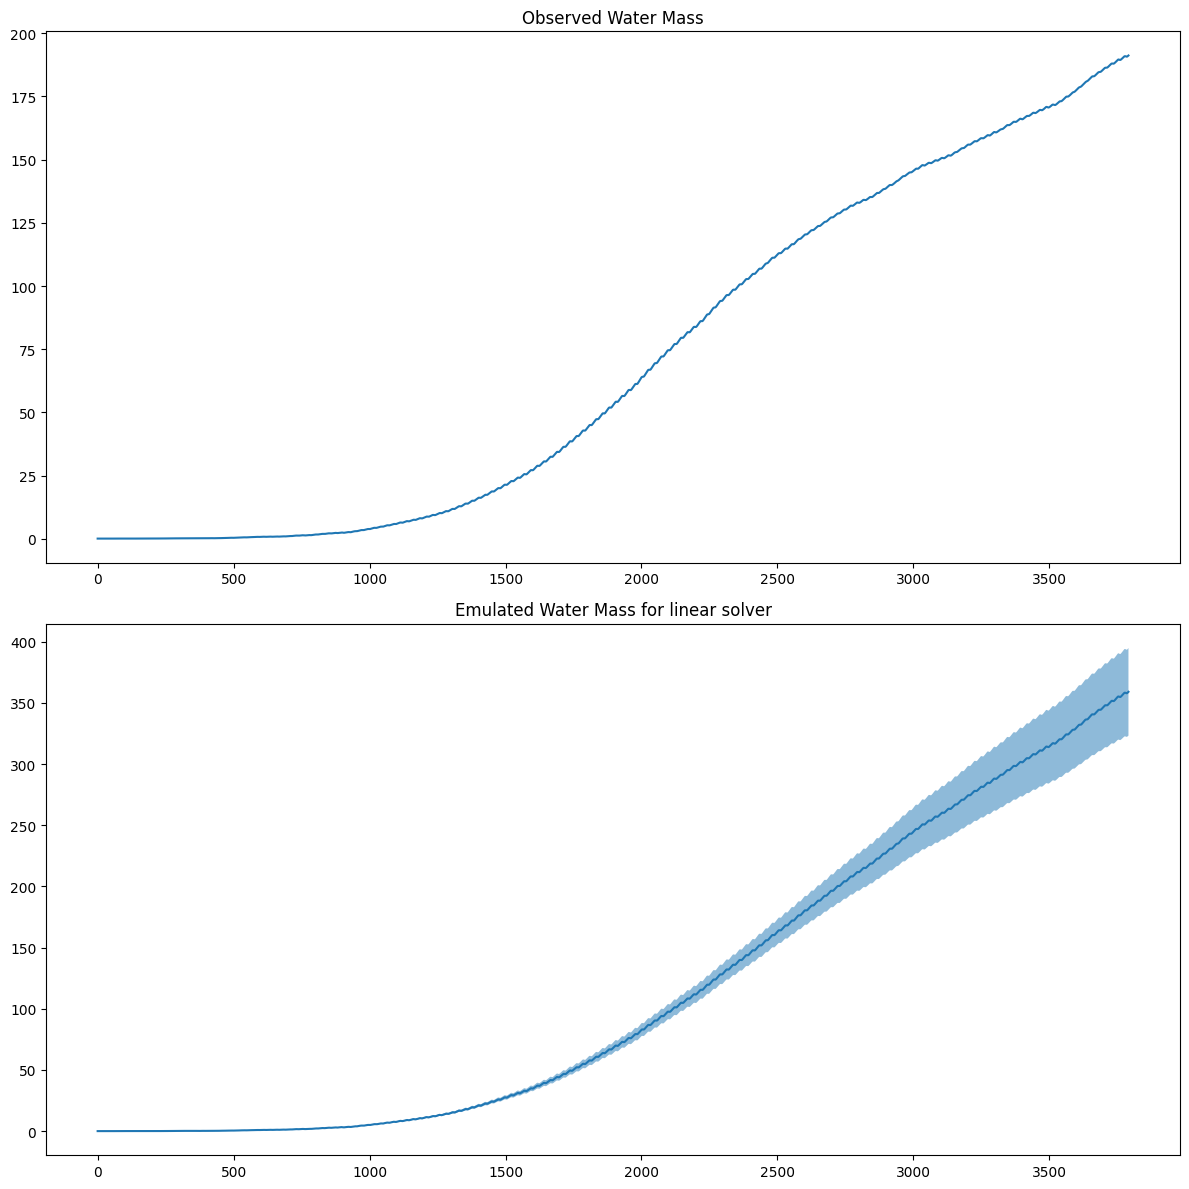

In [18]:
specification = UncertaintyAnalysisMethodModel(
	experiment_name="chaospy_uncertainty_analysis",
	parameter_spec=parameter_spec,
    observed_data=observed_data.w.values,
	solver="linear",
	algorithm="least_squares",
	method="sobol",
	order=2,
	n_samples=10,
	output_labels=["Water Mass"],
	flatten_Y=True,
	batch=False,
	method_kwargs=dict(rule="cholesky", normed=False, cross_truncation=1.0),
)

calibrator = UncertaintyAnalysisMethod(
	calibration_func=uncertainty_func, specification=specification, engine="chaospy"
)

calibrator.specify().execute().analyze()

We can see the results of the uncertainty analysis above. We have a deterministic and mechanistic fruit model, and by using a PCE surrogate model, we are able to construct a distribution of plausible trajectories for our simulated fruit water mass. We have the mean trajectory of our predicted water mass, alongside its standard deviation.

As we have yet to perform calibration, we also see that our trajectory is quite off from the observed data. Also note that we have taken a fairly small number of samples (10), so our results need to be taken with a grain of salt.

An uncertainty analysis is particulary useful for both temporal and spatial modelling (in our case temporal), as it tracks how uncertainty in model inputs or conditions spreads and evolves across both space and time. It helps reveal where and when predictions are most reliable in dynamic, location-dependent systems.

## Sensitivity analysis

We will next perform a sensitivity analysis to derive sensitivity indices for our 3 parameters (Growth.lp, Growth.lxAsy, Growth.kx). This will allow us to prioritise specific parameters for calibration using a combination of a data-driven approach (with our observed water mass data), consultation with domain experts, and a review of the available literature.

We will calculate Sobol sensitivity indices to quantify how the variation in the 3 input parameters of the model influences the variation in fruit water mass. [A detailed explaination of the Sobol methods may be found here.](https://link.springer.com/chapter/10.1007/978-3-030-51862-2_6). 

We'll first define a sensitivity analysis function which will return the discrepancy between observed and simulated fruit water mass values as determined by the mean squared error (MSE) metric. There are alternatives...we could return sensitivity indices for each time step if we wanted to perform a time-varying sensitivity analysis for instance. But we'll keep things simple.

In [20]:
def sensitivity_func(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None
) -> float | list[float]:
    model = JFruit2()
    props = model.load_properties()
    for k in parameters:
        props[k] = parameters[k]
    model.save_properties(props)

    model.run(
        properties = osp.join("data", "out", f"{model.sim_id}.properties")
    )
    simulated_data = model.results.w.values
    metric = MeanSquaredError()
    discrepancy = metric.calculate(observed_data, simulated_data)
    return discrepancy

[We'll use the Sobol method from the SALib library](https://salib.readthedocs.io/en/latest/), and take only 8 base samples. We'll construct bootstrap confidence intervals for our sensitivity indices.

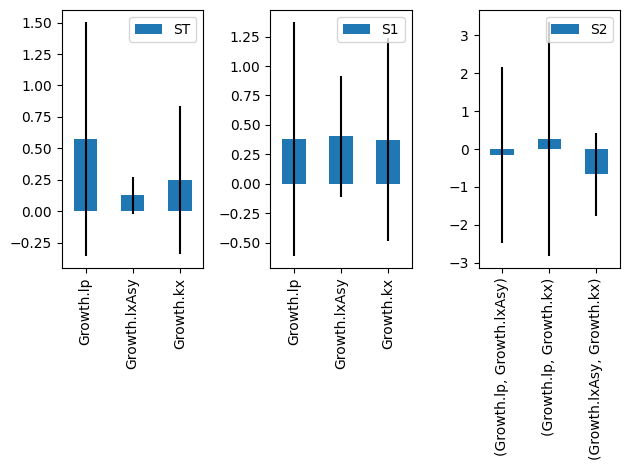

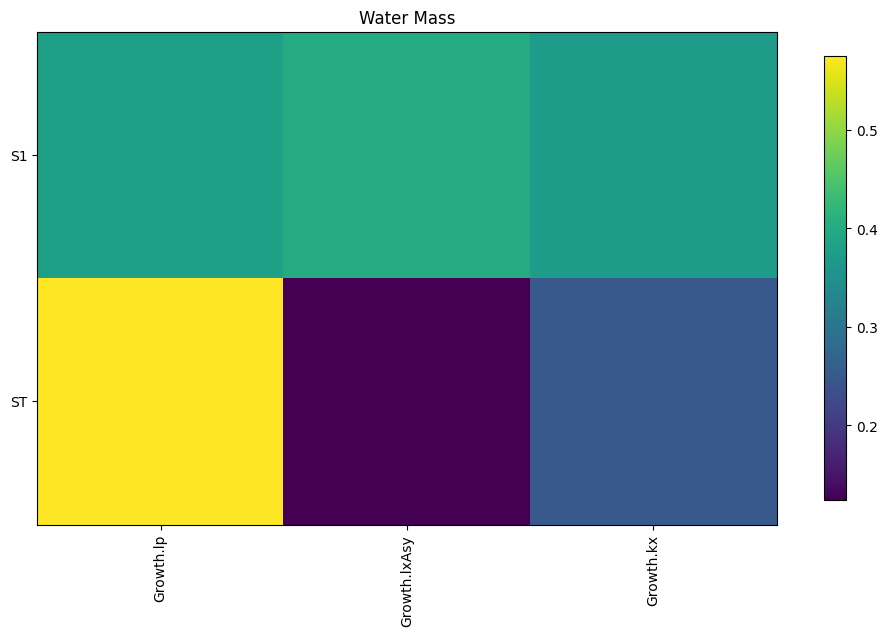

In [25]:
specification = SensitivityAnalysisMethodModel(
	experiment_name="salib_sensitivity_analysis",
	parameter_spec=parameter_spec,
	observed_data=observed_data.w.values,
	method="sobol",
	n_samples=8,
    n_jobs=1,
	output_labels=["Water Mass"],
	verbose=True,
	batched=False,
	method_kwargs=dict(calc_second_order=False, scramble=True),
	analyze_kwargs=dict(
		calc_second_order=False,
		num_resamples=30,
		conf_level=0.95,
	),
)

calibrator = SensitivityAnalysisMethod(
	calibration_func=sensitivity_func, specification=specification, engine="salib"
)

calibrator.specify().execute().analyze()

In [28]:
from SALib.analyze import sobol

print("JFruit2 sensitivity analysis")
print("=" * 60)

# Get results from the calibrator
sp = calibrator.implementation.sp
Y = sp._results
Si = sobol.analyze(sp, Y, calc_second_order=True)

output_labels = calibrator.specification.output_labels[0]  

s1_values = Si['S1']
st_values = Si['ST']
parameter_names = sp['names']

# results summary
sensitivity_df = pd.DataFrame({
    'Parameter': parameter_names,
    'S1 (direct effect)': s1_values,
    'ST (total effect)': st_values,
    'Interactions': st_values - s1_values
}).sort_values('ST (total effect)', ascending=False)

print(sensitivity_df.to_string(index=False, float_format='%.3f'))

print("=" * 60)
for _, row in sensitivity_df.iterrows():
    param = row['Parameter']
    s1 = row['S1 (direct effect)']
    st = row['ST (total effect)']
    
    print(f"\n• {param}: {st:.1%} total influence on {output_labels}")
    
    if 'Growth.lp' in param:
        print(f"  - Controls how quickly the fruit grows")
    elif 'Growth.lxAsy' in param:
        print(f"  - Sets the maximum potential fruit size")
    
    if st > 0.1:
        print(f"  - 🔴 HIGH importance - prioritize for calibration")
    elif st > 0.05:
        print(f"  - 🟡 MEDIUM importance - secondary calibration target")
    else:
        print(f"  - 🟢 LOW importance - can use literature values")


print("=" * 60)
most_important = sensitivity_df.iloc[0]
max_interaction = sensitivity_df['Interactions'].max()

print(f"• Most important parameter: {most_important['Parameter']} ({most_important['ST (total effect)']:.1%} influence)")
print(f"• Parameter interactions: {'Strong' if max_interaction > 0.1 else 'Weak'}")

if max_interaction > 0.1:
    print(f"  → Calibrate parameters together, not separately")
else:
    print(f"  → Parameters can be calibrated independently")

total_explained = np.sum(st_values)
print(f"• Model variance explained: {total_explained:.1%}")
if total_explained > 0.8:
    print(f"  → The parameters explain most model behaviours in the response variables")
else:
    print(f"  → The model outputs are not sensitive to the parameter set selected")

JFruit2 sensitivity analysis
   Parameter  S1 (direct effect)  ST (total effect)  Interactions
   Growth.lp               0.381              0.575         0.194
   Growth.kx               0.373              0.250        -0.123
Growth.lxAsy               0.402              0.125        -0.278

• Growth.lp: 57.5% total influence on Water Mass
  - Controls how quickly the fruit grows
  - 🔴 HIGH importance - prioritize for calibration

• Growth.kx: 25.0% total influence on Water Mass
  - 🔴 HIGH importance - prioritize for calibration

• Growth.lxAsy: 12.5% total influence on Water Mass
  - Sets the maximum potential fruit size
  - 🔴 HIGH importance - prioritize for calibration
• Most important parameter: Growth.lp (57.5% influence)
• Parameter interactions: Strong
  → Calibrate parameters together, not separately
• Model variance explained: 94.9%
  → The parameters explain most model behaviours in the response variables


The variation in the discrepancy between simulated and observed water mass data (the output) is most sensitive to variation in Growth.lp (the input), which is the conductivity of the composite membrane for water transport (phloem). 

We can see that varation in Growth.lxAsy has less of an influence. Growth.kx sits in between the other two parameters. 

Hence, we would want to focus on calibrating Growth.lp first. To reduce the possibility of overfitting, we may hold less influential parameters, such as Growth.lxAsy, constant while varying more influential parameters such as Growth.lp and Growth.kx.

Some of the confidence intervals for our indices contain negative values. In cases where any negative sensitivity indices are present, this may be indicative that numerical error has occurred and that we need to take more samples; it can also be due to Monte Carlo noise. In this example, the second order indices are unreliable.  

Note that we have taken a very small number of samples to speed up the sensitivity analysis. The formula for the Saltelli-Sobol sensitivity analysis is N×(2k+2), where N is the base number of samples and k is the number of parameters. So we have taken 8(2(3) + 2) = 64 samples. We might want to increase it to over 500 to 1000 samples.